In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import heapq
import time
import pandas as pd
import math

/tmp/ipykernel_26306/187924686.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  floor_plan = imageio.imread('./map/vivocity.png')
/tmp/ipykernel_26306/187924686.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  grid_map_img = imageio.imread('./map/vivocity_freespace.png')


Size of the map: (1000, 1000)
Occupied Cells: 823039
Free Cells: 176961


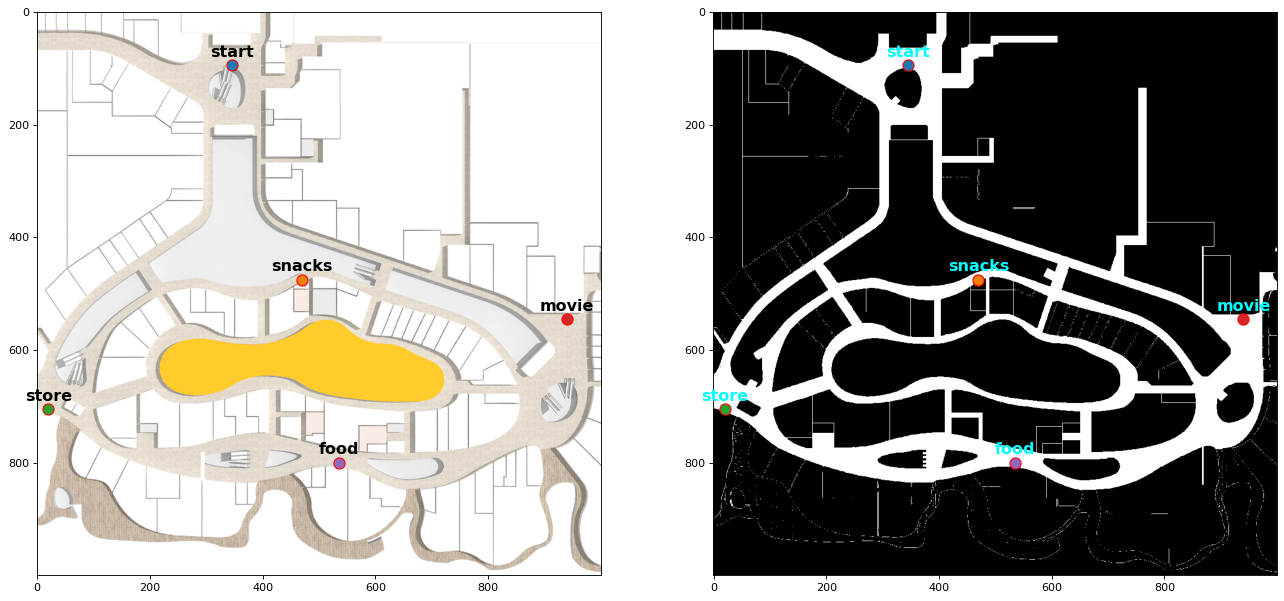

Cell start is free: True
Cell snacks is free: True
Cell store is free: True
Cell movie is free: True
Cell food is free: True


In [2]:
# Load the map
floor_plan = imageio.imread('./map/vivocity.png')
grid_map_img = imageio.imread('./map/vivocity_freespace.png')
grid_map = grid_map_img.transpose()
print("Size of the map:", grid_map.shape)
print("Occupied Cells:", np.count_nonzero(grid_map == 0))
print("Free Cells:", np.count_nonzero(grid_map == 255))

# Map resolution (Constant)
MAP_RES = 0.2 # each cell represents a 0.2m x 0.2m square in reality

# Locations on the map
locations = {'start':  [345, 95],    # Start from the level 2 Escalator
             'snacks': [470, 475],   # Garrett Popcorn
             'store':  [20, 705],    # DJI Store
             'movie':  [940, 545],   # Golden Village
             'food':   [535, 800],   # PUTIEN
            }

# A helper function to mark the locations on the map
def plot_locations(locations: dict, color: 'str'='black'):
    for key, value in locations.items():
        plt.plot(locations[key][0], locations[key][1], marker="o", markersize=10, markeredgecolor="red")
        plt.text(locations[key][0], locations[key][1]-15, s=key, fontsize='x-large', fontweight='bold', c=color, ha='center')
    return

# Plot the locaitons on the map 
plt.figure(figsize=(20, 10), dpi=80)
plt.subplot(1,2,1)
plt.imshow(floor_plan)
plot_locations(locations)
plt.subplot(1,2,2)
plt.imshow(grid_map_img, cmap='gray')
plot_locations(locations, color='cyan')
plt.show()

# Check if the designated locations are free
for key, value in locations.items():
    print(f"Cell {key} is free: {grid_map[value[0], value[1]] == 255}")

## Task 1

In [3]:
def obs_map(grid_map):
    obs = set()     # set for fast research
    # Find obstacles (==0, include boundary)
    obs_array = np.argwhere(grid_map==0)
    for t in obs_array:
        obs.add((t[0], t[1]))     
    return obs
obs = obs_map(grid_map)

In [4]:
# Astar
import math
import heapq
import datetime   

# Different kinds of heuristic type design
def heuristic(a, b):
    dx = abs(a[0] - b[0])
    dy = abs(a[1]- b[1])
    estimated_distance = abs(a[0] - b[0]) + abs(a[1] - b[1]) + (1.414 - 2) * min(dx, dy)
    return estimated_distance

# Get the neighbors of the current node
def get_neighbors(node, obs):
    found_collision = False  # 用于标记是否发现碰撞
    directions = [(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]
    result = []
    delta = math.floor((0.3 / 1.414) / 0.2)

    for direction in directions:
        neighbor = (node[0] + direction[0], node[1] + direction[1])
        for x in range(max(neighbor[0] - delta, 0), min(neighbor[0] + delta + 1, 1000)):
            for y in range(max(neighbor[1] - delta, 0), min(neighbor[1] + delta + 1, 1000)):
                if (x, y) in obs:
                    found_collision = True
                    break  # 发现碰撞时终止内部循环
            if found_collision:
                break  # 发现碰撞时终止外部循环
            
        if 0 <= neighbor[0] < grid_map.shape[0] and 0 <= neighbor[1] < grid_map.shape[1]:
            if grid_map[neighbor[0], neighbor[1]] == 255:  # Free space
                result.append(neighbor)
    return result

def a_star_search(start, goal, obs):
    open_set = []
    heapq.heappush(open_set, (0 + heuristic(start, goal), start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    close_set = []

    while not len(open_set) == 0:
        current = heapq.heappop(open_set)[1]
        close_set.append(current)

        if current == goal:
            break

        for next in get_neighbors(current, obs):
            new_cost = cost_so_far[current] + heuristic(current, next) + heuristic(next, goal)

            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                # priority = new_cost + heuristic(next, goal)
                heapq.heappush(open_set, (new_cost, next))
                came_from[next] = current
    cells = len(close_set)
    return came_from, cost_so_far, cells

def dijkstra(start, goal, obs):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    close_set = []

    while not len(open_set) == 0:
        current = heapq.heappop(open_set)[1]
        close_set.append(current)

        if current == goal:
            break

        for next in get_neighbors(current, obs):
            new_cost = cost_so_far[current] + heuristic(current, next)

            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                # priority = new_cost + heuristic(current, next)
                heapq.heappush(open_set, (new_cost, next))
                came_from[next] = current
    cells = len(close_set)
    return came_from, cost_so_far, cells

def greedy(start, goal, obs):
    open_set = []
    heapq.heappush(open_set, (heuristic(start, goal), start))
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0
    close_set = []

    while not len(open_set) == 0:
        current = heapq.heappop(open_set)[1]
        close_set.append(current)

        if current == goal:
            break

        for next in get_neighbors(current, obs):
            new_cost = heuristic(next, goal)

            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                # priority = new_cost + heuristic(current, goal)
                heapq.heappush(open_set, (new_cost, next))
                came_from[next] = current
    cells = len(close_set)
    return came_from, cost_so_far, cells

def reconstruct_path(came_from, start, goal):
    total_distance = 0
    current = goal
    path = []
    while current != start:
        path.append(current)
        total_distance += heuristic(current, came_from[current])
        current = came_from[current]

    path.append(start)
    path.reverse()
    total_distance = 0.2 * total_distance
    return path, total_distance

def plan_and_plot_path(locations, obs, method, grid_map_img):
    paths = {}
    distances = {}
    visit_order = ['start', 'snacks', 'store', 'movie', 'food']
    colors = ['red', 'blue', 'green', 'yellow', 'magenta']  # 颜色列表，用于不同的路径

    for start_location in visit_order:
        distances[start_location] = {}
        
        plt.figure(figsize=(10, 10))
        plt.imshow(grid_map_img, cmap='gray')
        plot_locations(locations, 'cyan')
        
        color_index = 0  # 用于从颜色列表中选择颜色
        
        for end_location in visit_order:
            if start_location == end_location:
                continue  # 跳过相同的起点和终点
            
            # 根据所选方法执行路径搜索
            if method == 'Astar':
                came_from, _, _ = a_star_search(tuple(locations[start_location]), tuple(locations[end_location]), obs)
            elif method == 'Dijkstra':
                came_from, _, _ = dijkstra(tuple(locations[start_location]), tuple(locations[end_location]), obs)
            elif method == 'Greedy':
                came_from, _, _ = greedy(tuple(locations[start_location]), tuple(locations[end_location]), obs)
                
            path, distance = reconstruct_path(came_from, tuple(locations[start_location]), tuple(locations[end_location]))
            paths[f"{start_location} to {end_location}"] = path
            distances[start_location][end_location] = distance

            # 绘制路径
            x_coords, y_coords = zip(*path)
            plt.plot(x_coords, y_coords, color=colors[color_index], linewidth=3, 
                     label=f"{start_location} to {end_location} ({distance:.2f}m)")
            color_index = (color_index + 1) % len(colors)  # 更新颜色索引
        
        plt.title(f"Paths from {start_location}")
        plt.axis('off')
        plt.legend()
        plt.show()

    # 创建 DataFrame
    df = pd.DataFrame(distances, index=visit_order, columns=visit_order)
    df.fillna(0, inplace=True)
    return paths, df
    

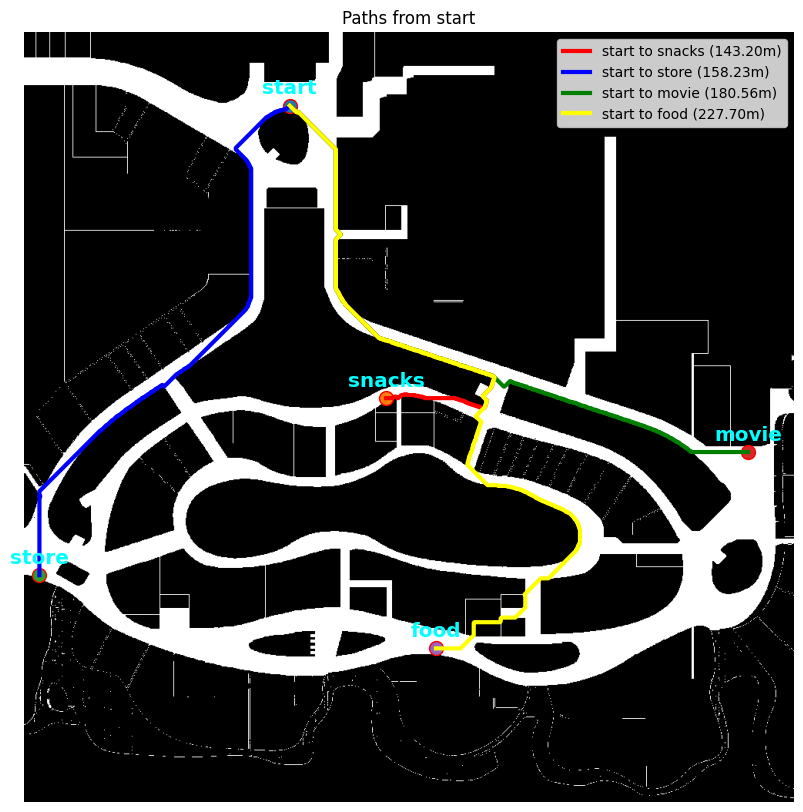

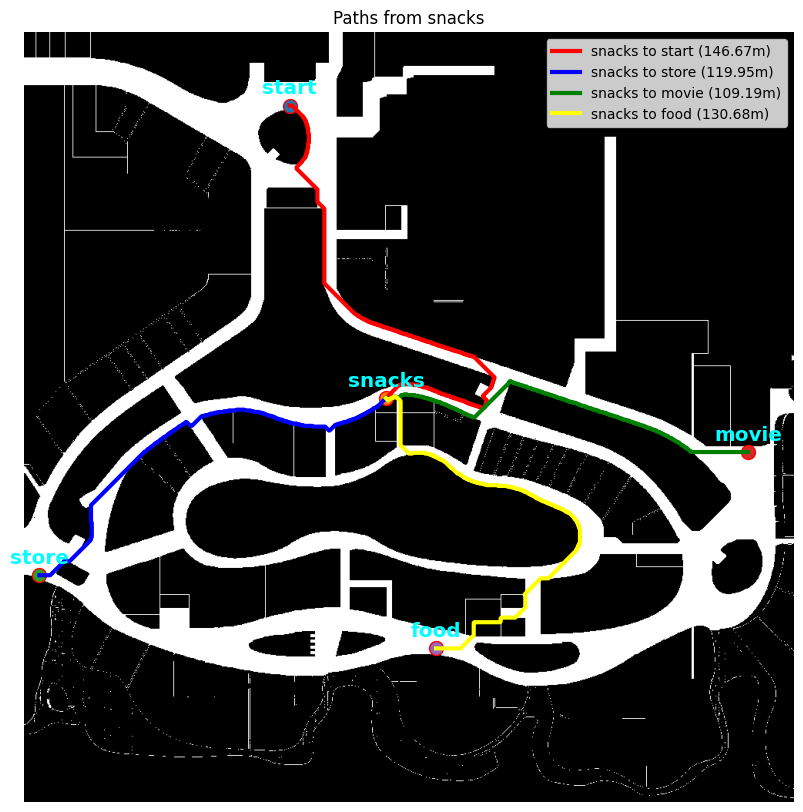

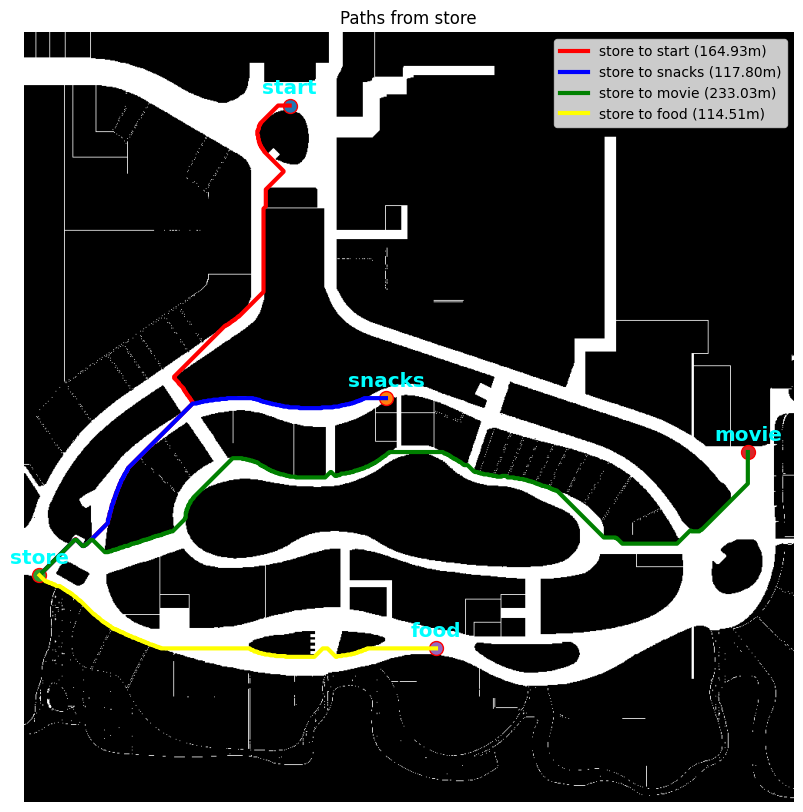

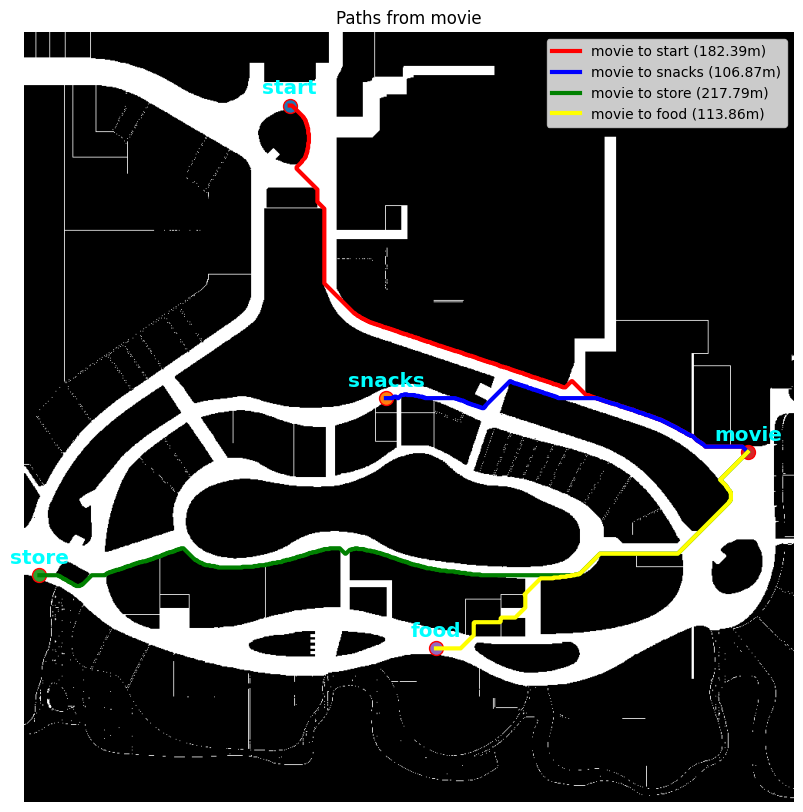

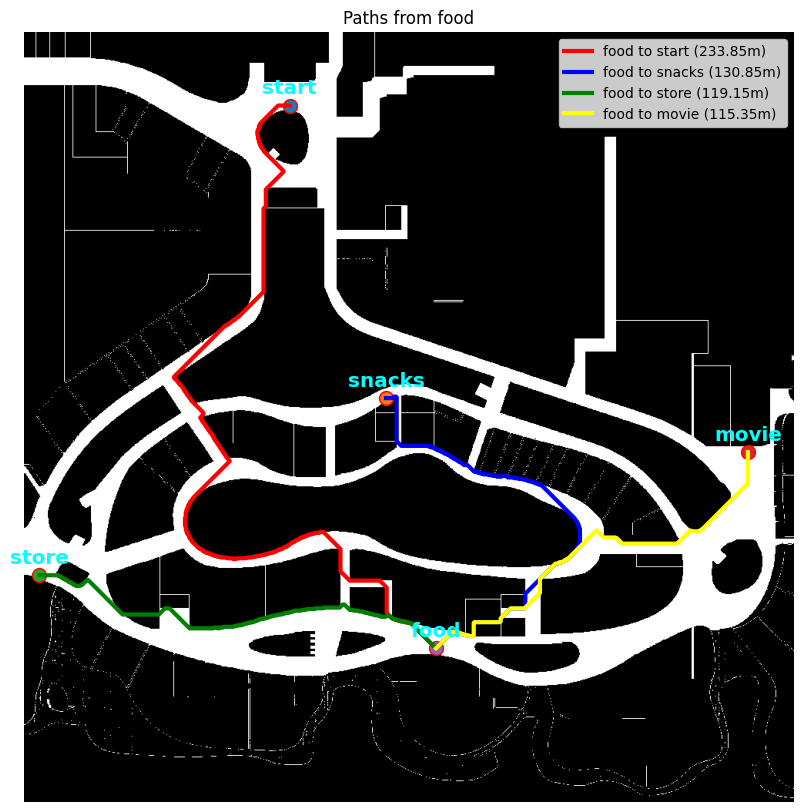

Totoal running time is 50.741s
           start    snacks     store     movie      food
start     0.0000  146.6732  164.9276  182.3852  233.8548
snacks  143.1956    0.0000  117.7956  106.8684  130.8504
store   158.2272  119.9484    0.0000  217.7852  119.1460
movie   180.5636  109.1868  233.0256    0.0000  115.3472
food    227.6996  130.6848  114.5092  113.8568    0.0000


In [5]:
start_time_part = time.time()
path, df = plan_and_plot_path(locations, obs, 'Astar',grid_map_img)
end_time_part = time.time()
print(f"Totoal running time is {end_time_part - start_time_part:.3f}s")
print(df)

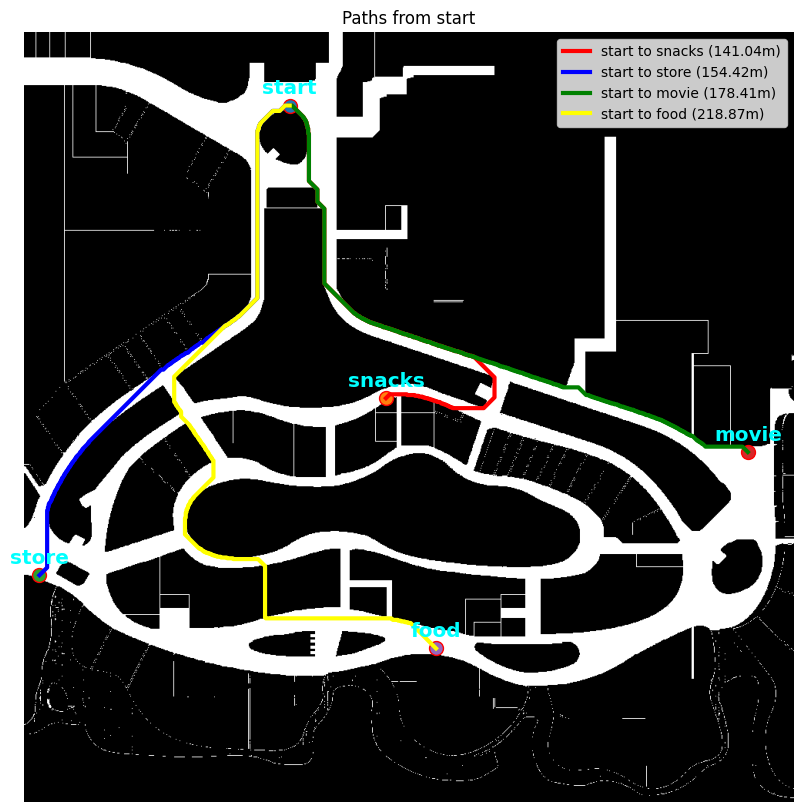

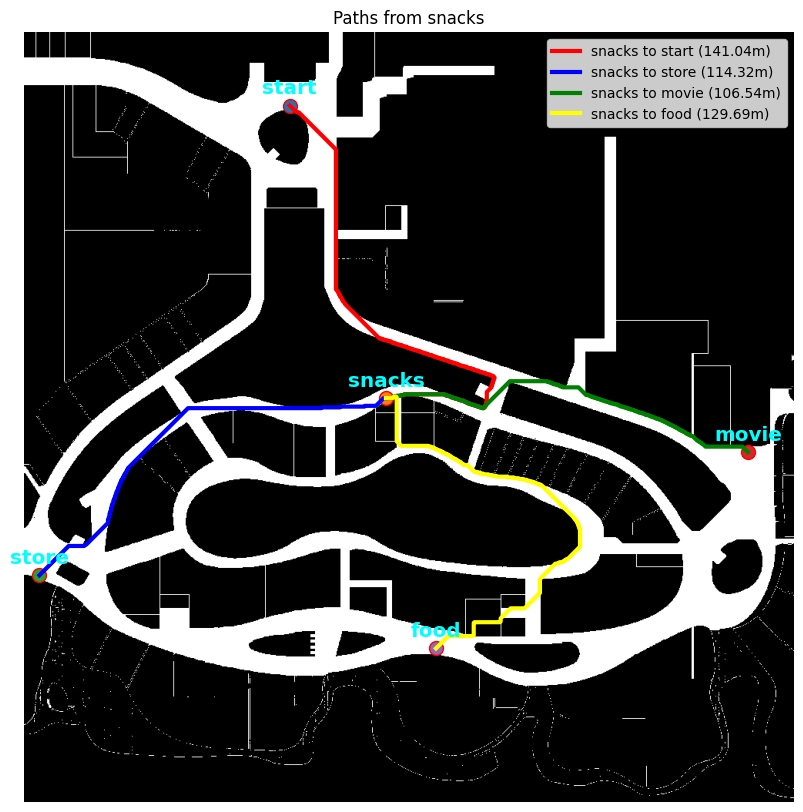

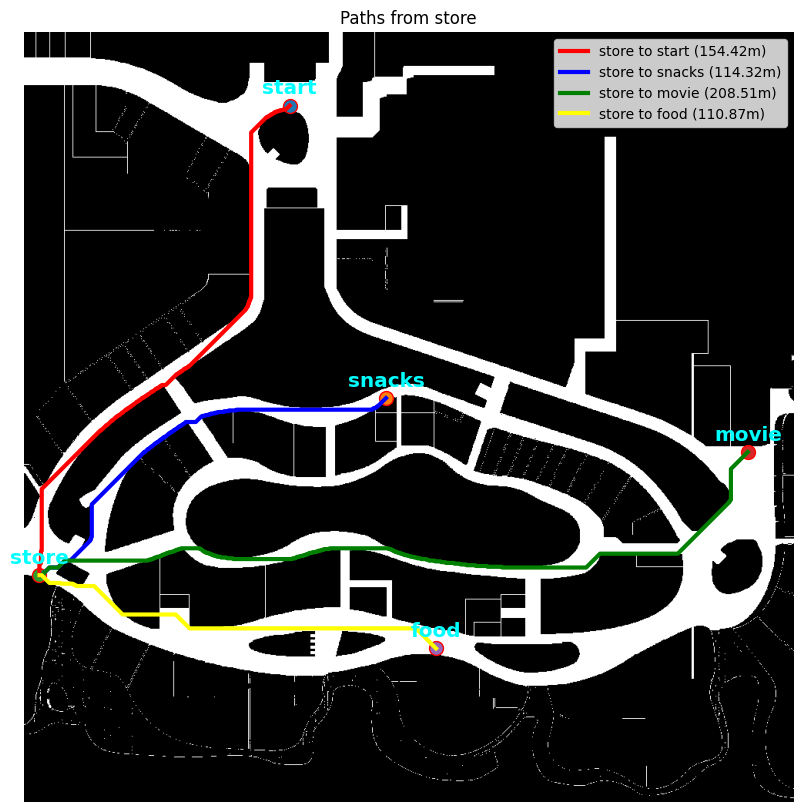

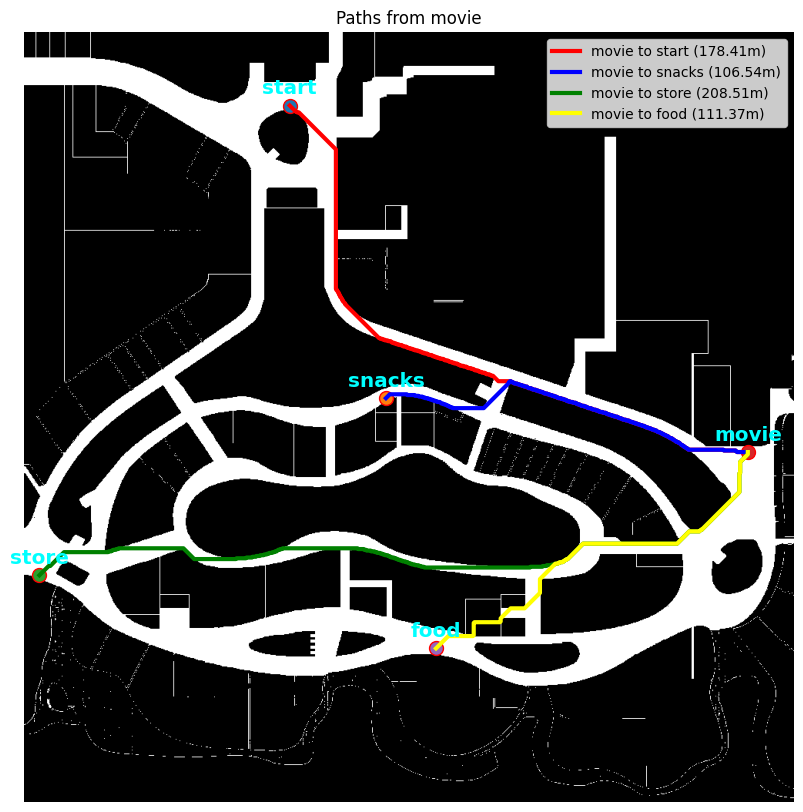

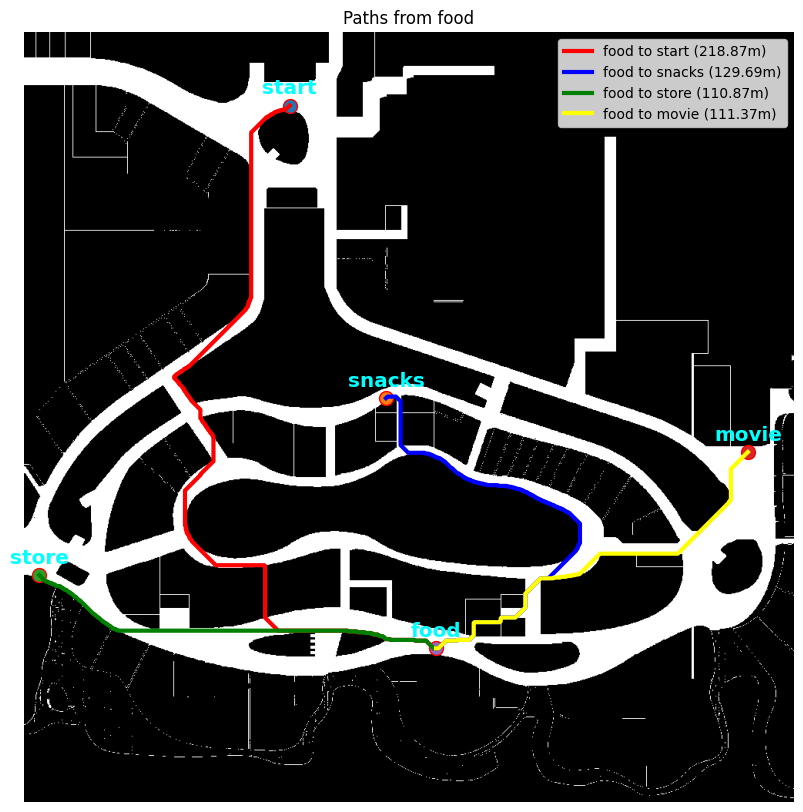

Totoal running time is 75.381s
           start    snacks     store     movie      food
start     0.0000  141.0428  154.4184  178.4108  218.8744
snacks  141.0428    0.0000  114.3180  106.5372  129.6912
store   154.4184  114.3180    0.0000  208.5116  110.8660
movie   178.4108  106.5372  208.5116    0.0000  111.3728
food    218.8744  129.6912  110.8660  111.3728    0.0000


In [6]:
start_time_part = time.time()
path, df = plan_and_plot_path(locations, obs, 'Dijkstra',grid_map_img)
end_time_part = time.time()
print(f"Totoal running time is {end_time_part - start_time_part:.3f}s")
print(df)

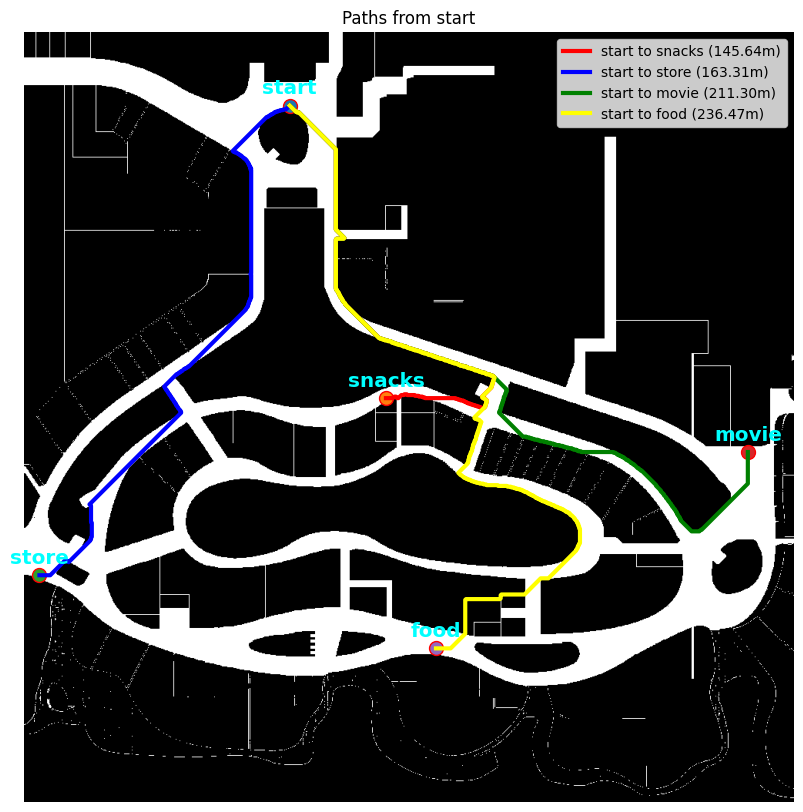

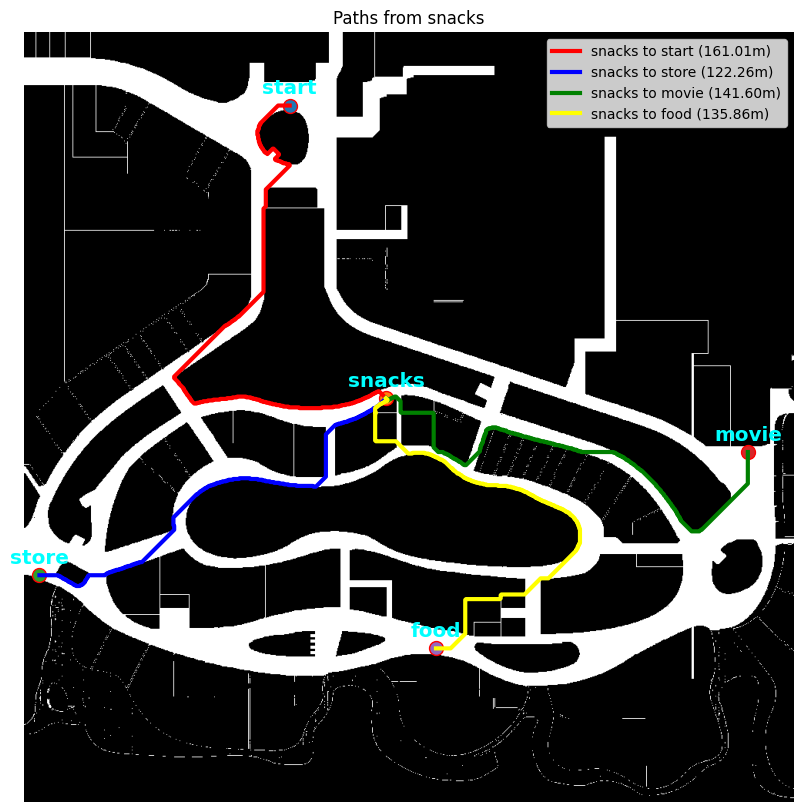

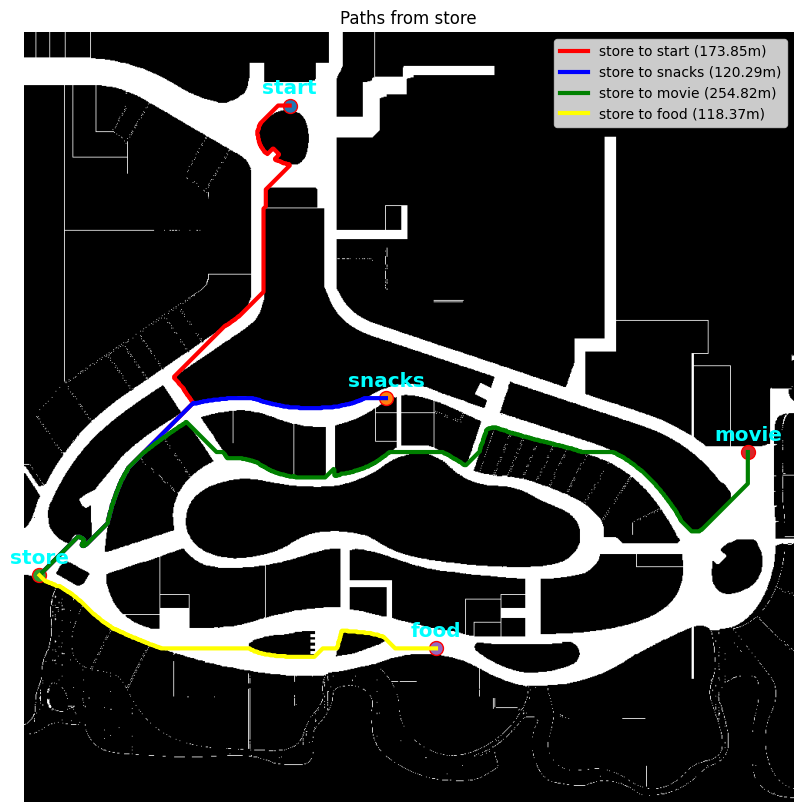

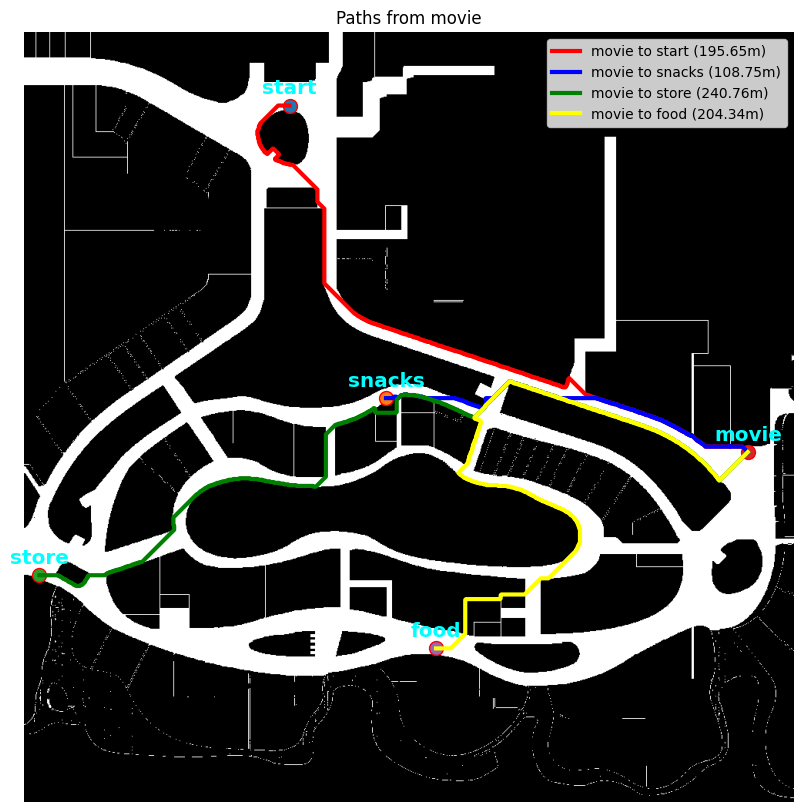

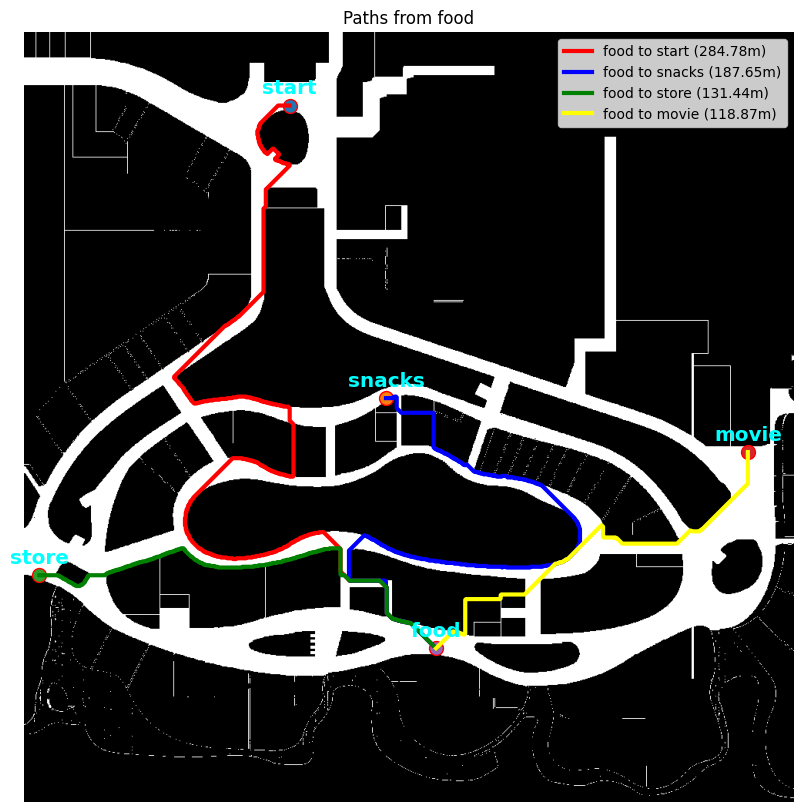

Totoal running time is 2.975s
           start    snacks     store     movie      food
start     0.0000  161.0120  173.8524  195.6488  284.7796
snacks  145.6440    0.0000  120.2924  108.7512  187.6452
store   163.3124  122.2568    0.0000  240.7632  131.4416
movie   211.2996  141.5968  254.8216    0.0000  118.8708
food    236.4716  135.8568  118.3716  204.3404    0.0000


In [7]:
start_time_part = time.time()
path, df = plan_and_plot_path(locations, obs, 'Greedy',grid_map_img)
end_time_part = time.time()
print(f"Totoal running time is {end_time_part - start_time_part:.3f}s")
print(df)

## Task 2

In [8]:
import itertools
import numpy
import matplotlib.pyplot as plt
import pandas as pd

# def plan_shortest_path(locations, distances):
#     visit_order = ['snacks', 'movie', 'food', 'store']

#     shortest_distance = float('inf')
#     shortest_path = None

#     # 遍历所有可能的路径组合
#     for path in itertools.permutations(visit_order):
#         total_distance = 0
#         total_distance += distances['start'][path[0]]  # 从起点到第一个地点的距离
#         for i in range(len(path) - 1):
#             total_distance += distances[path[i]][path[i+1]]  # 计算相邻两个地点之间的距离
#         total_distance += distances[path[-1]]['start']  # 从最后一个地点回到起点的距离

#         # 更新最短路径和距离
#         if total_distance < shortest_distance:
#             shortest_distance = total_distance
#             shortest_path = path

#     return shortest_path, shortest_distance

# # 距离字典
# distances = {
#     'start': {'snacks': 73.642, 'movie': 92.758, 'food': 114.444, 'store': 77.064},
#     'snacks': {'start': 73.642, 'movie': 55.742, 'food': 71.144, 'store': 58.574},
#     'movie': {'start': 92.758, 'snacks': 55.742, 'food': 61.540, 'store': 113.562},
#     'food': {'start': 114.444, 'snacks': 71.144, 'movie': 61.540, 'store': 60.770},
#     'store': {'start': 77.064, 'snacks': 58.574, 'movie': 113.562, 'food': 60.770}
# }
def plan_shortest_path(locations, df):
    visit_order = ['snacks', 'movie', 'food', 'store']

    shortest_distance = float('inf')
    shortest_path = None

    # 遍历所有可能的路径组合
    for path in itertools.permutations(visit_order):
        total_distance = 0
        total_distance += df.loc['start', path[0]]  # 从起点到第一个地点的距离
        for i in range(len(path) - 1):
            total_distance += df.loc[path[i], path[i+1]]  # 计算相邻两个地点之间的距离
        total_distance += df.loc[path[-1], 'start']  # 从最后一个地点回到起点的距离

        # 更新最短路径和距离
        if total_distance < shortest_distance:
            shortest_distance = total_distance
            shortest_path = path

    return shortest_path, shortest_distance

start_time = time.time()
# 规划最短路径
shortest_path, shortest_distance = plan_shortest_path(locations, df)
# shortest_path, shortest_distance = plan_shortest_path(locations, distances)
end_time = time.time()
# 输出结果
shortest_path = ('start',) + shortest_path + ('start',)
print("Shortest path:", shortest_path)
print(f"Shortest distance:{shortest_distance}m")
print("running time:",end_time - start_time)

Shortest path: ('start', 'snacks', 'movie', 'food', 'store', 'start')
Shortest distance:670.3179999999977m
running time: 0.0018229484558105469


In [9]:
import random

class Particle:
    def __init__(self, sequence):
        self.sequence = sequence
        self.fitness = 0

def calculate_distance(sequence, distance_matrix):
    total_distance = 0
    for i in range(len(sequence) - 1):
        current_location = sequence[i] - 1  # 将序列值减去1以匹配索引
        next_location = sequence[i + 1] - 1  # 将序列值减去1以匹配索引
        total_distance += distance_matrix[current_location][next_location]
    return total_distance


def initialize_population(population_size, num_locations):
    population = []
    for _ in range(population_size):
        sequence = [2, 3, 4, 5]  # 初始顺序为1，2，3，4，5
        random.shuffle(sequence)    
        # 在序列开头和结尾添加1
        sequence.insert(0, 1)  # 在开头添加1
        sequence.append(1)  # 在结尾添加1
        particle = Particle(sequence)
        population.append(particle)
    return population

def update_particle_velocity(particle, global_best_sequence, c1, c2):
    new_sequence = [1] + global_best_sequence[1:-1] + [1]
    random.shuffle(new_sequence[1:-1])  # 随机排列2，3，4，5
    particle.sequence = new_sequence  # 更新粒子序列

def update_global_best_particle(particles):
    global_best_particle = min(particles, key=lambda x: x.fitness)
    return global_best_particle.sequence

# def pso_algorithm(distance_matrix, population_size=50, max_iterations=100, c1=2, c2=2):
#     num_locations = len(distance_matrix)
#     particles = initialize_population(population_size, num_locations)
#     global_best_sequence = None
#     global_best_fitness = float('inf')

#     for _ in range(max_iterations):
#         for particle in particles:
#             particle.fitness = calculate_distance(particle.sequence, distance_matrix)
#             global_best_fitness = min(global_best_fitness, particle.fitness)
#             if particle.fitness == global_best_fitness:
#                 global_best_sequence = particle.sequence
        
#         for particle in particles:
#             update_particle_velocity(particle, global_best_sequence, c1, c2)
        
#         global_best_sequence = update_global_best_particle(particles)

    return global_best_sequence, global_best_fitness
def pso_algorithm(df_distance, population_size=50, max_iterations=100, c1=2, c2=2):
    num_locations = len(df_distance)
    particles = initialize_population(population_size, num_locations)
    global_best_sequence = None
    global_best_fitness = float('inf')

    for _ in range(max_iterations):
        for particle in particles:
            particle.fitness = calculate_distance(particle.sequence, df_distance.values)
            global_best_fitness = min(global_best_fitness, particle.fitness)
            if particle.fitness == global_best_fitness:
                global_best_sequence = particle.sequence
        
        for particle in particles:
            update_particle_velocity(particle, global_best_sequence, c1, c2)
        
        global_best_sequence = update_global_best_particle(particles)

    return global_best_sequence, global_best_fitness


# 运行粒子群算法
best_sequence, best_fitness = pso_algorithm(df)
best_sequence = [df.columns[idx - 1] for idx in best_sequence]
# global_best_sequence, global_best_fitness = pso_algorithm(df)
print("Best sequence:", best_sequence)
print("Best fitness (total distance):", best_fitness)

Best sequence: ['start', 'snacks', 'movie', 'food', 'store', 'start']
Best fitness (total distance): 670.3179999999977
